## L'analyse des données avec les modèles entraînés sur colab

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
from skimage.io import imread , imshow
from skimage.transform import resize
from tensorflow.keras.models import load_model
import random
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score, classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array


2023-12-28 21:05:29.712326: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
model = load_model("data/models/colab/best_model_ori.h5")
model_plant = load_model('data/models/colab/best_model_plant.h5')
model_aug = load_model('data/models/colab/best_model_aug.h5')

### le model avec la base de data-science-bowl-2018

In [3]:
model.summary()

Model: "x-resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, 256, 256, 3)          9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['bn_data[0][0]']             
 g2D)                                                                                             
                                                                                         

### Chargement des données

In [4]:
train_ids  = next(os.walk("data/kaggle/stage1_train"))[1]
height , width = 256 , 256
x_ori = np.zeros((len(train_ids) , height , width , 3) , dtype = np.uint8 )
y_ori = np.zeros((len(train_ids) , height , width , 1) , dtype = bool)

In [5]:
train_dir ="data/kaggle/stage1_train/"

for n , id_ in enumerate(train_ids):
    path = train_dir + id_
    img = imread(path +  '/images/' + id_ + '.png')[: , : , : 3]
    img = resize(img , (height , width ) , mode = 'constant' , preserve_range = True)
    x_ori[n] = img
    mask = np.zeros((height , width , 1 ) , dtype = bool)
    for mask_file in next(os.walk(path + '/masks/' ))[2] :
        mask_ =  imread(path + '/masks/' + mask_file )
        mask_ = resize(mask_ , (height , width ) ,mode = 'constant' , preserve_range = True)
        mask_ = np.expand_dims(mask_ , axis = -1 )
        mask = np.maximum(mask , mask_)
    y_ori[n] = mask

In [6]:
print(x_ori.shape)
print(y_ori.shape)

(670, 256, 256, 3)
(670, 256, 256, 1)


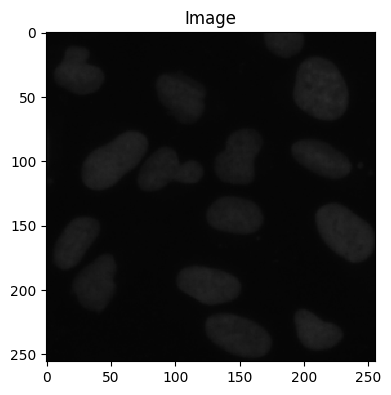

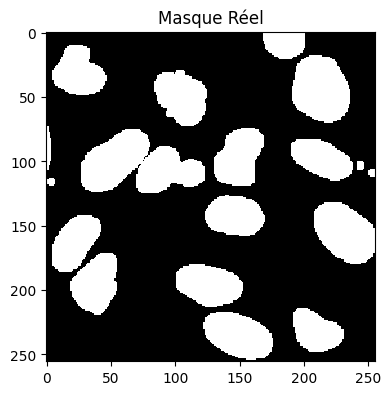

In [7]:
idx = random.randint(0, len(train_ids))
plt.figure(figsize=(4, 4))
imshow(x_ori[idx])
plt.title('Image')
plt.show()
plt.figure(figsize=(4, 4))
imshow(y_ori[idx])
plt.title('Masque Réel')
plt.show()

In [8]:
trainx_ori, testx_ori, trainy_ori, testy_ori = train_test_split(x_ori, y_ori, test_size=0.3, random_state=8)
print(trainx_ori.shape)
print(testx_ori.shape)
print(trainy_ori.shape)
print(testy_ori.shape)

(469, 256, 256, 3)
(201, 256, 256, 3)
(469, 256, 256, 1)
(201, 256, 256, 1)


In [9]:
preds_test_ori = model.predict(testx_ori, verbose=1)
preds_test_t = (preds_test_ori > 0.5).astype(np.uint8)

7/7 [==============================] - 63s 9s/step


201


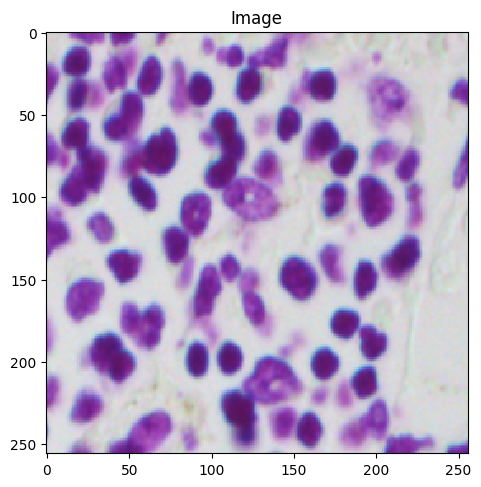

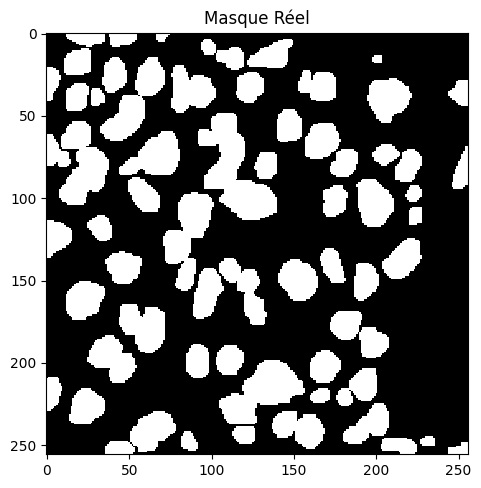

/Users/MyMac/Documents/univReims/M1/1/DeepLearning/project/segmentation_unet_plus/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


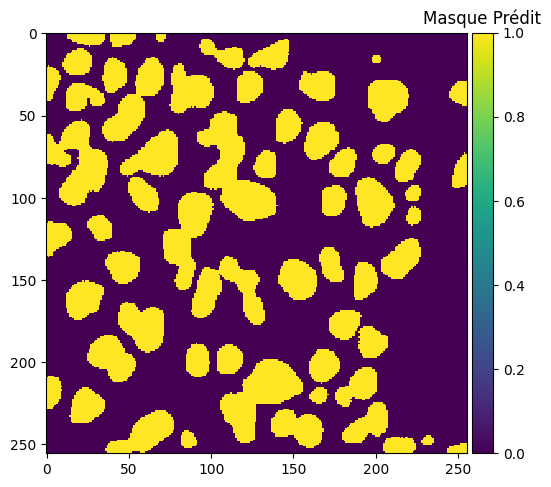

In [10]:
print(len(testx_ori))
ix = random.randint(0, len(testx_ori))
imshow(testx_ori[ix])
plt.title('Image')
plt.show()
imshow(testy_ori[ix])
plt.title('Masque Réel')
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.title('Masque Prédit')
plt.show()

### le model avec la base de plantDoc_leaf_dissease

In [11]:
model_plant.summary()

Model: "x-resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, 256, 256, 3)          9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['bn_data[0][0]']             
 g2D)                                                                                             
                                                                                         

### Chargement des données

In [12]:
def count_files_in_folder(folder_path):
    files = os.listdir(folder_path)
    files = [file for file in files if os.path.isfile(os.path.join(folder_path, file))]
    num_files = len(files)
    return num_files

In [13]:
test_ids = count_files_in_folder("data/plantDoc_leaf_disease/data/test/images")
print(test_ids)

119


In [14]:
height , width = 256 , 256

In [15]:
DATA_DIR = 'data/plantDoc_leaf_disease'

def get_image_folder(train=True, augmented=False):
    if train:
        if augmented:
            return (os.path.join(DATA_DIR, 'aug_data', 'train', 'images'), os.path.join(DATA_DIR, 'aug_data', 'train', 'masks'))
        else:
            return (os.path.join(DATA_DIR, 'data', 'train', 'images'), os.path.join(DATA_DIR, 'data', 'train', 'masks'))
    else:
        if augmented:
            return (os.path.join(DATA_DIR, 'aug_data', 'test', 'images'), os.path.join(DATA_DIR, 'aug_data', 'test', 'masks'))
        else:
            return (os.path.join(DATA_DIR, 'data', 'test', 'images'), os.path.join(DATA_DIR, 'data', 'test', 'masks'))


def load_data(images_folder, masks_folder, size, target_size=(256, 256)):
    x = np.zeros((size , target_size[0] , target_size[1] , 3) , dtype=np.uint8)
    y = np.zeros((size , target_size[0] , target_size[1] , 1) , dtype=np.uint8)
    n = 0
    for image_name in os.listdir(images_folder):
        if image_name.endswith('.jpg'):
          image_path = os.path.join(images_folder, image_name)
          img = imread(image_path)[: , : , : 3]
          img = resize(img , target_size , mode = 'constant' , preserve_range = True)
          x[n] = img

        #   mask = np.zeros((target_size[0], target_size[1], 1), dtype=np.uint8)
          mask_filename = image_name.split('.')[0] + '.png'
          mask_ = os.path.join(masks_folder, mask_filename)

          if imread(mask_).ndim == 3:
            mask_ = imread(mask_)[: , : , 0]  # Sélectionnez le canal R (ou G ou B) si nécessaire
          else:
            mask_ =  imread(mask_)

          mask_ = resize(mask_, target_size, mode='constant', preserve_range=True)
          mask_ = np.nan_to_num(mask_)  # Remplace les NaN par 0
          mask_[mask_ > 0] = 1
          
          mask_ = np.expand_dims(mask_, axis=-1)

          y[n] = mask_
          n += 1
    print(f"{n} images chargées")
    return x, y

In [16]:
images_folder, masks_folder = get_image_folder(train=False, augmented=False)
print(images_folder)
print(masks_folder)

data/plantDoc_leaf_disease/data/test/images
data/plantDoc_leaf_disease/data/test/masks


In [17]:
images_plant, masks_plant = load_data(images_folder, masks_folder, test_ids)

print(images_plant.shape)
print(masks_plant.shape)

118 images chargées
(119, 256, 256, 3)
(119, 256, 256, 1)


115


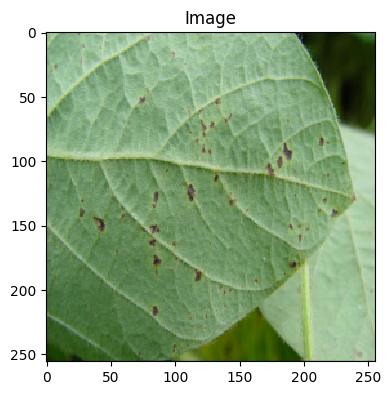

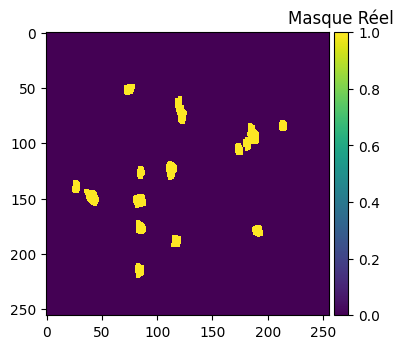

In [18]:
idx = random.randint(0, test_ids-1)
print(idx)
plt.figure(figsize=(4, 4))
imshow(images_plant[idx])
plt.title('Image')
plt.show()
plt.figure(figsize=(4, 4))
imshow(masks_plant[idx])
plt.title('Masque Réel')
plt.show()

In [19]:
trainx_plant, testx_plant, trainy_plant, testy_plant = train_test_split(images_plant, masks_plant, test_size=0.3, random_state=8)
print(trainx_plant.shape)
print(testx_plant.shape)
print(trainy_plant.shape)
print(testy_plant.shape)

(83, 256, 256, 3)
(36, 256, 256, 3)
(83, 256, 256, 1)
(36, 256, 256, 1)


In [20]:
preds_test_plant = model_plant.predict(testx_plant, verbose=1)
preds_test_t_plant = (preds_test_plant > 0.5).astype(np.uint8)

2/2 [==============================] - 11s 1s/step


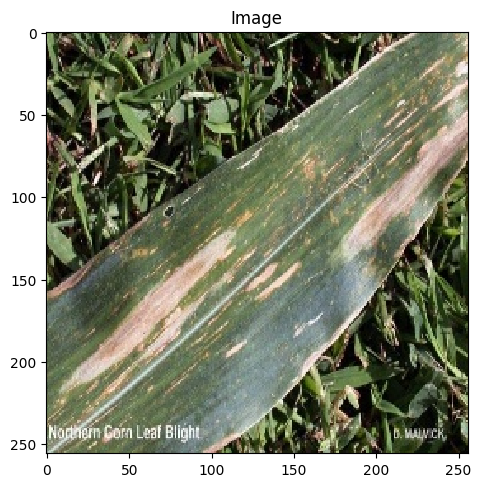

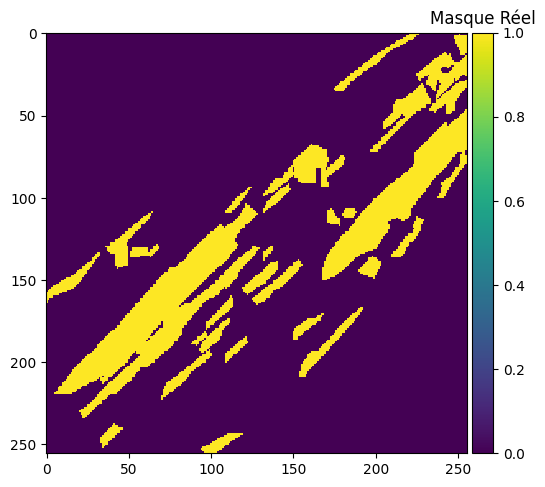

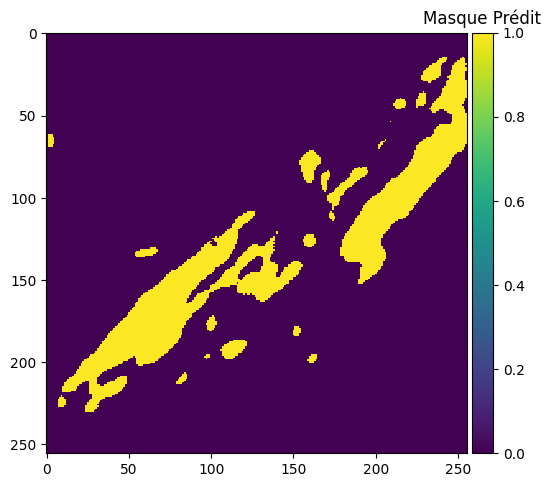

In [30]:
ix = random.randint(0, len(testx_plant)-1)
imshow(testx_plant[ix])
plt.title('Image')
plt.show()
imshow(testy_plant[ix])
plt.title('Masque Réel')
plt.show()
imshow(np.squeeze(preds_test_t_plant[ix]))
plt.title('Masque Prédit')
plt.show()

### le model avec la base de plantDoc_leaf_dissease avec les images augmentées

In [22]:
model_aug.summary()

Model: "x-resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, 256, 256, 3)          9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['bn_data[0][0]']             
 g2D)                                                                                             
                                                                                         

### Chargement des données

In [31]:
test_ids = count_files_in_folder("data/plantDoc_leaf_disease/aug_data/test/images")
print(test_ids)

589


In [32]:
images_folder, masks_folder = get_image_folder(train=False, augmented=True)
print(images_folder)
print(masks_folder)

data/plantDoc_leaf_disease/aug_data/test/images
data/plantDoc_leaf_disease/aug_data/test/masks


In [33]:
images_aug, masks_aug = load_data(images_folder, masks_folder, test_ids)

print(images_aug.shape)
print(masks_aug.shape)

588 images chargées
(589, 256, 256, 3)
(589, 256, 256, 1)


260


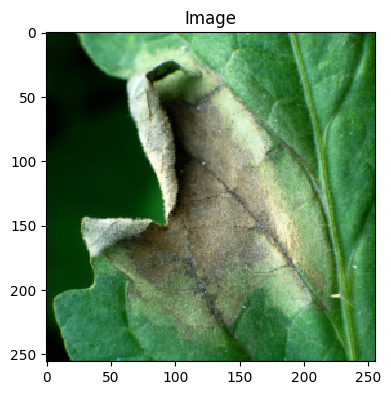

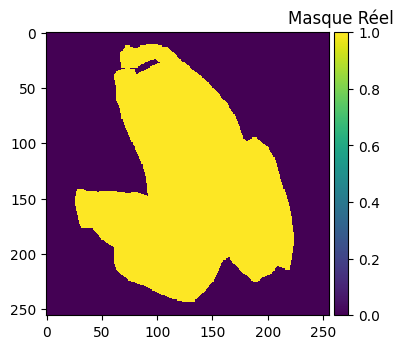

In [34]:
idx = random.randint(0, test_ids-1)
print(idx)
plt.figure(figsize=(4, 4))
imshow(images_aug[idx])
plt.title('Image')
plt.show()
plt.figure(figsize=(4, 4))
imshow(masks_aug[idx])
plt.title('Masque Réel')
plt.show()

In [35]:
trainx_aug, testx_aug, trainy_aug, testy_aug = train_test_split(images_aug, masks_aug, test_size=0.3, random_state=8)
print(trainx_aug.shape)
print(testx_aug.shape)
print(trainy_aug.shape)
print(testy_aug.shape)

(412, 256, 256, 3)
(177, 256, 256, 3)
(412, 256, 256, 1)
(177, 256, 256, 1)


In [36]:
preds_test_aug = model_aug.predict(testx_aug, verbose=1)
preds_test_t_aug = (preds_test_aug > 0.5).astype(np.uint8)

6/6 [==============================] - 56s 9s/step


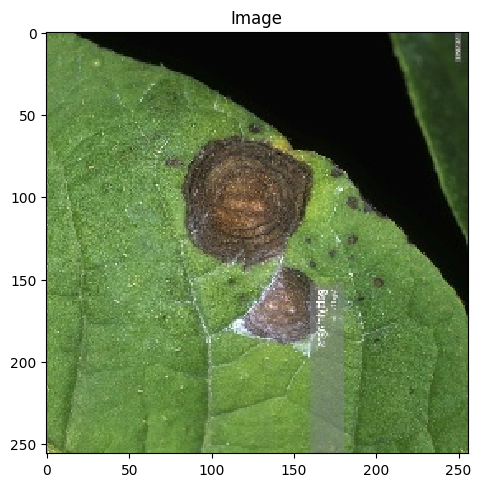

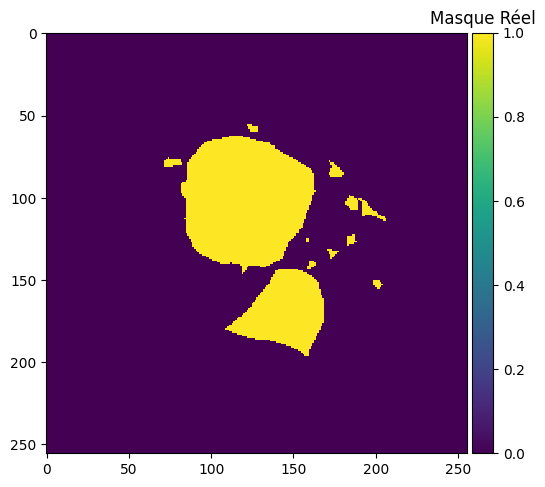

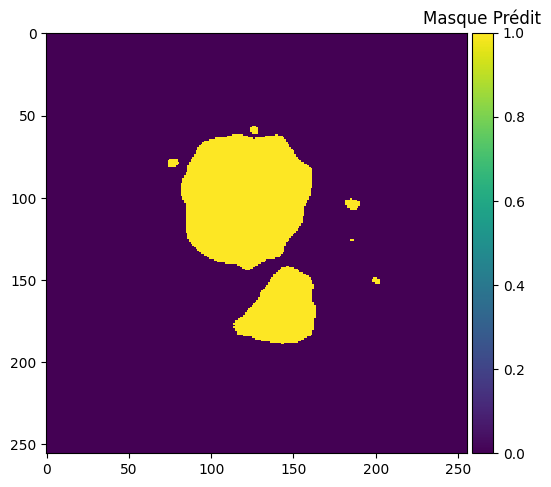

In [37]:
ix = random.randint(0, len(testx_aug)-1)
imshow(testx_aug[ix])
plt.title('Image')
plt.show()
imshow(testy_aug[ix])
plt.title('Masque Réel')
plt.show()
imshow(np.squeeze(preds_test_t_aug[ix]))
plt.title('Masque Prédit')
plt.show()

### Comparaison des résultats

In [38]:
def evaluate_model(model, test_x, test_y, data_name):
    test_y = test_y.astype(int)
    predictions = model.predict(test_x)
    predictions_binary = (predictions > 0.5).astype(int)

    test_y = test_y.reshape(-1)
    predictions_binary = predictions_binary.reshape(-1)
    
    accuracy = accuracy_score(test_y, predictions_binary)
    precision = precision_score(test_y, predictions_binary)
    recall = recall_score(test_y, predictions_binary)
    f1 = f1_score(test_y, predictions_binary)
    jaccard = jaccard_score(test_y, predictions_binary)

    print(f"Performance du modèle sur la base de données {data_name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Jaccard Index: {jaccard}")


In [39]:
evaluate_model(model, testx_ori, testy_ori, 'Original')
evaluate_model(model_plant, testx_plant, testy_plant, 'PlantDoc')
evaluate_model(model_aug, testx_aug, testy_aug, 'PlantDoc Augmentée')

7/7 [==============================] - 58s 8s/step
Performance du modèle sur la base de données Original:
Accuracy: 0.9882850457186723
Precision: 0.9721130174534556
Recall: 0.960315136686159
F1 Score: 0.9661780627967019
Jaccard Index: 0.9345691245538987
2/2 [==============================] - 10s 1s/step
Performance du modèle sur la base de données PlantDoc:
Accuracy: 0.9137098524305556
Precision: 0.8516681735053584
Recall: 0.6536794971191946
F1 Score: 0.7396537480785806
Jaccard Index: 0.586865511720264
6/6 [==============================] - 49s 8s/step
Performance du modèle sur la base de données PlantDoc Augmentée:
Accuracy: 0.9607423254325564
Precision: 0.9160452584163347
Recall: 0.8647216391107225
F1 Score: 0.8896438477797375
Jaccard Index: 0.8012238649741438
